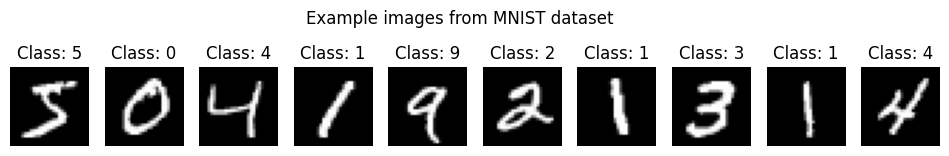

In [272]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

## Very basic autoencoder

In [297]:


class Autoencoder(nn.Module):
    def __init__(self, patch_size, masked_img_size):
        super(Autoencoder, self).__init__()
        self.patch_size = patch_size
        self.masked_img_size = masked_img_size
        self.patch_dim = masked_img_size*16*1  # Grayscale image, so 1 channel
        self.embed_dim = masked_img_size*32
        
        # Encoding layer
        self.enc_fc = nn.Linear(self.patch_dim, self.embed_dim)
        self.enc_act = nn.ReLU()

        # Decoding layer
        self.dec_fc = nn.Linear(self.embed_dim, 28*28)
        self.dec_act = nn.Sigmoid()

    def _initialize_weights(self):
    # Xavier initialization for Linear layers
        nn.init.xavier_uniform_(self.enc_fc.weight)
        nn.init.xavier_uniform_(self.dec_fc.weight)

    def encode(self, x):
        x = self.enc_fc(x)
        x = self.enc_act(x)
        print(x.shape)
        x = x.reshape(128, self.masked_img_size, 32)
        return x

    def decode(self, x):
        x = self.dec_fc(x)
        x = self.dec_act(x)
        return x

    def forward(self, x):
        # Encoding and decoding patches
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [300]:

patch_size = 4
mask_ratio = 0.5
masked_img_size = 49- int(49 * mask_ratio)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

def apply_mask(imgs, mask_ratio):
    batch_size = imgs.shape[0]
    num_patches = imgs.shape[1]
    mask_count = int(num_patches * mask_ratio)
    masks = torch.zeros(batch_size, num_patches)

    for i in range(batch_size):
        mask_idx = torch.randperm(num_patches)[:mask_count]
        masks[i, mask_idx] = 1  # Set the selected indices to 1 (mask)
    
    return masks

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs_orig = imgs.reshape(128, -1)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs, imgs_orig

batch_size = 128
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)


## Visualize

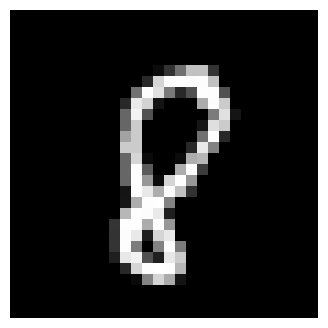

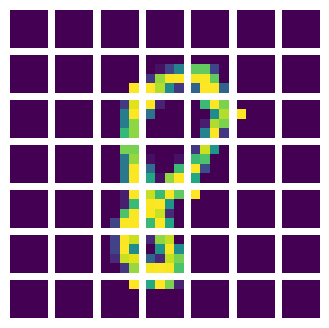

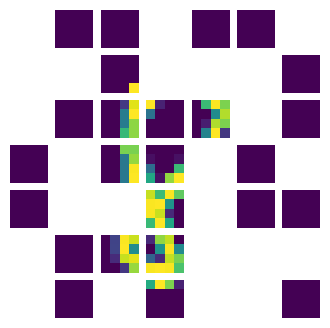

torch.Size([25, 4, 4])


In [301]:
imgs, imgs_orig = next(iter(train_loader))
img, imgs_orig = imgs[0], imgs_orig[0]
plt.figure(figsize=(4,4))
plt.imshow(imgs_orig.reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()

fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

masks = apply_mask(imgs, mask_ratio)

mask = masks[0]
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    if mask[n] == 0:
        ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

print(img[mask.eq(0)].shape)  # Zero out the masked patches

In [302]:
# Initialize the model
model = Autoencoder(patch_size=patch_size, masked_img_size=masked_img_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Training loop with patch masking
def train(model, train_loader, mask_ratio, patch_size):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        imgs, imgs_orig = batch
        imgs = imgs.to(device)
        imgs_orig = imgs_orig.to(device)

        batch_size, num_patches, h, w = imgs.shape
        imgs = imgs.view(batch_size, num_patches,  h * w)
        # print(batch.shape)

        masks = apply_mask(imgs, mask_ratio)
        # Apply random mask
        
        img_data = torch.zeros([batch_size, masked_img_size, h * w], device=device)
        for id, mask in enumerate(masks):
            data = imgs[id][mask.eq(0)]
            img_data[id] = data
            
        img_data = img_data.view(-1, masked_img_size*16)
        print(img_data.shape)
        
        # Forward pass with visible patches
        output = model.encode(img_data)
        print(output.shape)
        # # Reconstruct and compute the loss with the original full image patches
        loss = loss_fn(output, imgs_orig)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    running_loss /= len(train_loader)
    return running_loss

# Training loop
epochs = 5
for epoch in range(epochs):
    train_loss = train(model, train_loader, mask_ratio, patch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 400])
torch.Size([128, 800])
torch.Size([128, 25, 32])


ValueError: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 25, 32])) is deprecated. Please ensure they have the same size.

torch.Size([128, 784])
torch.Size([784])
torch.Size([1, 784])


<function matplotlib.pyplot.show(close=None, block=None)>

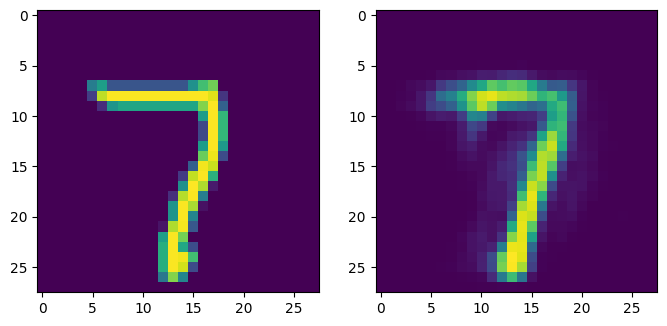

In [283]:
# Select a random sample
samples, orig = next(iter(test_loader))
print(orig.shape)
masks = apply_mask(samples, mask_ratio)

sample = samples[0]
orig = orig[0]
mask = masks[0]

print(orig.shape)
# Use the encode and decode functions
masked = sample[mask.eq(0)]
masked = masked.view(-1, masked_img_size*16)

decoded_img = model(masked).detach()
print(decoded_img.shape)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig.reshape(28,28))


plt.subplot(1,2,2)
plt.imshow(decoded_img.reshape(28,28))
plt.show




In [306]:
mask_token = nn.Parameter(torch.zeros(1, 32))
torch.nn.init.normal_(mask_token, std=.02)
mask_token.shape #torch.Size([1, 32])
tokens = torch.zeros((49, 64))

tokens[~mask.bool()] = decoder_tokens[1:, :]
tokens[mask.bool()] = torch.cat([mask_token]*(49-(~mask.bool()).sum()))